![Alice in Wonderland](images/alice-in-wonderland.png)

## Introduction
This notebook contains exploratory notes on objectively measuring the performance of Retrieval Augmented Generation (RAG) using the RAG Assessment [ragas](https://docs.ragas.io/en/stable/index.html) python module. We'll use the classic children's book "Alice's Adventures in Wonderland" as the source of context for our experiments.

## Motivation
RAG is one of the most popular methods for enriching a Large Language Model (LLM) with context about a specific domain. While there's an incredible amount of knowledge across a wide array of domains embedded with leading models such as llama3, chatGPT and Gemini, they have no exposure to private data sets or data created after they were pre-trained. RAG is one efficient way to address this. Fine-tuning is another approach.

## Evaluation
We will focus on measuring the overall performance of the RAG pipeline in this notebook and restrict our experimentation to optimising the embedding stage. This is a reasonable starting place, however future improvements may come from assessing the performance of individual stages of the RAG and optimising them appropriately. This may include optimising embedding and search, preparing the context as a result of potentially multiple queries against the vector store (in the case of a dense embedding) and of course the LLM used to generate the answers.

## Dataset
The most capable LLMs have been training on a huge corpus of data and can answer questions on a staggeringly broad range of subjects. If we were to ask llama3 a question about "Alice's Adventures in Wonderland" it will almost certainly do an excellent job of providing an answer. This is because the text is accessible at the [Gutenberg Project](https://www.gutenberg.org/ebooks/11) and is a favourite subject of mathematicians and logicians so there will have been plenty of examples during pre-training. We'll prevent the LLM from using embedded knowledge about the book by providing a system prompt. This may not guarantee prior knowledge will be ignored but for the purposes of our experiment, it should be sufficient.

## Models
Alice's Adventure's in Wonderland is approximately 27,000 words long. At the time of writing, Google's Gemini 1.5 pro has a maximum context window of 1 million tokens. If we combined this with the top performing embedding model [voyage-large-2-instruct](https://docs.voyageai.com/docs/embeddings) with a maximum context length of 16,000 tokens we could fit the entire book into the LLMs working memory with only a searches. This brute force approach may provide good results but at a cost of resources used and latency. There's also a concern that the embedding vector may be less meaningful as the size of the text encoding (chuck_size) increases.

For the purpose of experimentation we'll use a more modest starting combination of embedding model and transformer model.

- Embedding model: [mxbai-embed-large-v1](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1). [Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard) rank #16.
- Decoder model: [Llama3-8b-Instruct](https://ollama.com/library/llama3:instruct) llama3 with 4-bit quantisation and a 2k context window.


We may explore tweaking the context window size later, but for now, let's get some baseline data.

Let's start by downloading the source text and remove all text that's not part of the story. In particular, there's a lengthy copyright and legal notice at the end of the document. If we don't remove it, it will get embedded into the vector store and potentially be used to create questions and answers about the book. This is clearly not what we want, so it needs to be removed. 

Note: We'll be using `wget`, `tail`, `head` and `wc` to explore the source text. If you are on a mac, you'll need to install wget with `brew` or some other package manager.

In [ ]:
!wget https://www.gutenberg.org/ebooks/11.txt.utf-8 -O ./data/alice.txt

In [1]:
!tail -n +29 ./data/alice.txt  | head -n -353 > ./data/alice-modified.txt 

In [2]:
!head -n 10 ./data/alice-modified.txt

Alice’s Adventures in Wonderland

by Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0

Contents

 CHAPTER I.     Down the Rabbit-Hole
 CHAPTER II.    The Pool of Tears


In [3]:
!tail -n 10 ./data/alice-modified.txt

would, in the after-time, be herself a grown woman; and how she would
keep, through all her riper years, the simple and loving heart of her
childhood: and how she would gather about her other little children,
and make _their_ eyes bright and eager with many a strange tale,
perhaps even with the dream of Wonderland of long ago: and how she
would feel with all their simple sorrows, and find a pleasure in all
their simple joys, remembering her own child-life, and the happy summer
days.

THE END


In [4]:
!wc -w ./data/alice-modified.txt

26524 ./data/alice-modified.txt


The start and end sections of the modified text looks correct. As we expected, the text has just under 27,000 words.

Let's now open the document and split it up into small chunks. We'll use `langchain_text_splitters.RecursiveCharacterTextSplitter`so let's install `langchain_community`.

In [1]:
pip install langchain_community

In [1]:
with open("./data/alice-modified.txt") as f:
    alice_in_wonderland = f.read()

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

[RecursiveCharacterTextSplitter](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/recursive_text_splitter/) breaks up text into chunks up to a `chuck_size` limit while trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.

Note: `chunk_size` is the number of characters not words or tokens.

In [3]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=128,
    length_function=len,
    is_separator_regex=False
)

We'll explore using different values for `chunk_size` later so it will be helpful to include its value as metadata in the vector store. We can then filter searches based on `chunk_size`. More on this later.

In [4]:
chunk_size = 512
chunk_overlap = 128

alice = text_splitter.create_documents([alice_in_wonderland], metadatas=[{"filename": "alice-modified.txt",
                                                                         "chunk_size": chunk_size,
                                                                         "chunk_overlap": chunk_overlap}])

this returns a list of `langchain_core.documents.base.Document`. Let's take a look at the first one to familarise ourselves with the structure.

In [5]:
alice[42].dict()

{'page_content': '“You ought to be ashamed of yourself,” said Alice, “a great girl like\nyou,” (she might well say this), “to go on crying in this way! Stop\nthis moment, I tell you!” But she went on all the same, shedding\ngallons of tears, until there was a large pool all round her, about\nfour inches deep and reaching half down the hall.',
 'metadata': {'filename': 'alice-modified.txt',
  'chunk_size': 512,
  'chunk_overlap': 128},
 'type': 'Document'}

we have an element for `page_content`, one for `meta_data` and one for `type`. Let's get a feel for how the text is broken down into chunks. In particular, let's see the effects of `chunk_overlap`.

In [6]:
for i in range(41,44):
    print(f"{alice[i].dict()['page_content']}\n")

Poor Alice! It was as much as she could do, lying down on one side, to
look through into the garden with one eye; but to get through was more
hopeless than ever: she sat down and began to cry again.

“You ought to be ashamed of yourself,” said Alice, “a great girl like
you,” (she might well say this), “to go on crying in this way! Stop
this moment, I tell you!” But she went on all the same, shedding
gallons of tears, until there was a large pool all round her, about
four inches deep and reaching half down the hall.

After a time she heard a little pattering of feet in the distance, and
she hastily dried her eyes to see what was coming. It was the White
Rabbit returning, splendidly dressed, with a pair of white kid gloves
in one hand and a large fan in the other: he came trotting along in a
great hurry, muttering to himself as he came, “Oh! the Duchess, the
Duchess! Oh! won’t she be savage if I’ve kept her waiting!” Alice felt
so desperate that she was ready to ask help of any one; so, 

Each chuck captures a few sentences of text or paragraph as we expect. This should provide a reasonable starting place to start our experimentation. However, because the `chuck_size` is quite small, even with an `chunk_overlap` equal to approximately 25% of `chunk_size`, there's no overlapping text in this small sample. This is probably due to `RecursiveCharacterTextSplitter` preferring to split on sentences and paragraphs.

Let's look at the average size (in words) produced by `RecursiveCharacterTextSplitter`.

In [11]:
number_of_words = 0
for chunk in range(len(alice)):
    number_of_words += len(dict(alice[chunk])["page_content"].split())
print(f"The average number of words per chunk is: {number_of_words/len(alice):.0f}")

The average number of words per chunk is: 71


The `mxbai-embed-large` embedding model has a [recommended](https://www.mixedbread.ai/docs/embeddings/mxbai-embed-large-v1#model-description) input sequence length of up to 512 tokens and produces an embedding vector of 1024 dimensions. The sequence length of 512 tokens will set an upper bound on the length of segments we can embed, but with a starting average chuck length of 71 words, there's plenty of opportunity to increase the chunk length during testing without hitting this upper limit.

We'll use AstraDB for the vectorStore. DataStax has made it really easy to get started with this serverless DBaaS based on Apache Cassandra. Just following the [Quick Start](https://docs.datastax.com/en/astra-db-serverless/get-started/quickstart.html) guide and you'll have a Database, Collection and API key in a few minutes. When creating the collection, set the number of dimensions to 1,024 and specify a similarity measure of cosine (the angle between the vectors being compared). The dimensionality is determined by the embedding model we've chosen.

Create a .env file with values for each of the following variables:

- ASTRA_DB_APPLICATION_TOKEN
- ASTRA_DB_API_ENDPOINT
- ASTRA_DB_COLLECTION

We'll also need to install AstraDB python modules. I used `ragstack-ai` but `astrapy` should also be sufficient if you only want to only use AstraDB.

In [ ]:
pip install ragstack-ai

In [7]:
import os
from dotenv import load_dotenv
from langchain_astradb import AstraDBVectorStore

load_dotenv()

True

We'll be using the `mxbai-embed-large` embedding model hosted using ollama via the URL `http://192.168.1.111:11434`. We want greater consistency and determinism in both the embedding model and later the encodermodel, hence the low value for temperature.

In [8]:
from langchain.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings

embedding_model = OllamaEmbeddings(model="mxbai-embed-large", base_url="http://192.168.1.111:11434", temperature=0, top_p=0.05, top_k=10)

We are just about ready to create the first set of vector embeddings in the vector store. Let's create a connection.

In [9]:
vstore = AstraDBVectorStore(
    embedding=embedding_model,
    collection_name=os.environ["ASTRA_DB_COLLECTION"],
    token=os.environ["ASTRA_DB_APPLICATION_TOKEN"],
    api_endpoint=os.environ["ASTRA_DB_API_ENDPOINT"],
)

/home/djh/Development/python/alice-in-wonderland-rag-experiments/venv/lib/python3.10/site-packages/langchain_astradb/utils/astradb.py:196: UserWarning: Astra DB collection 'alice_in_wonderland' is detected as having indexing turned on for all fields (either created manually or by older versions of this plugin). This implies stricter limitations on the amount of text each string in a document can store. Consider reindexing anew on a fresh collection to be able to store longer texts.
  if not self._validate_indexing_policy(


and add the chucks to the vector store.

In [11]:
inserted_ids = vstore.add_documents(alice)

In [12]:
print(f"\nInserted {len(inserted_ids)} documents.")

Let's now focus on the decoder_model, the LLM that will make sense of the context provided by the vector store together with the question and try to answer the question.

In [10]:
from langchain_core.prompts import ChatPromptTemplate

system_prompt = ( "You are an assistant for question-answering tasks. "
                 "Answer each question based ONLY on the supplied context. "
                 "If you don't know the answer, say you don't know the answer. "
                 "Respond with at most three sentences. Keep answers concise and factual.\n\n" "{context}" )

prompt = ChatPromptTemplate.from_messages( [ ("system", system_prompt), ("human", "{input}"), ] )

Let's now create a simple q&A chain consisting of the decoder model and vector store retriever.

In [11]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

decoder_model = Ollama(model="llama3:instruct", base_url="http://192.168.1.111:11434", temperature=0, top_p=0.05, top_k=10)

qa_chain = create_stuff_documents_chain(decoder_model, prompt)
retriever = vstore.as_retriever(search_kwargs={'k': 1, 'filter': {"chunk_size": 512}})

rag_chain = create_retrieval_chain(retriever, qa_chain)

It might be helpful to use this helpful function to display the results (answers) based on the questions and context provided to the model.

In [12]:
def print_rag_question_and_answer(result: dict) -> str:
    return f"Question: {result['input']}\nAnswer: {result['answer']}\nChunksize: {result['context'][0].dict()['metadata']['chunk_size']}\n\n"

In [13]:
result = rag_chain.invoke({"input": "Who is Alice?"})
result

{'input': 'Who is Alice?',
 'context': [Document(page_content='“Who are _you?_” said the Caterpillar.\n\nThis was not an encouraging opening for a conversation. Alice replied,\nrather shyly, “I—I hardly know, sir, just at present—at least I know\nwho I _was_ when I got up this morning, but I think I must have been\nchanged several times since then.”\n\n“What do you mean by that?” said the Caterpillar sternly. “Explain\nyourself!”\n\n“I can’t explain _myself_, I’m afraid, sir,” said Alice, “because I’m\nnot myself, you see.”\n\n“I don’t see,” said the Caterpillar.', metadata={'filename': 'alice-modified.txt', 'chunk_size': 512, 'chunk_overlap': 128})],
 'answer': "Alice is a character who has just been talking to the Caterpillar in Wonderland. She's unsure of her current identity because she thinks she may have changed several times since waking up that morning."}

This is promising. Let's see how the answer improves when we increase the similarity search to include the three nearest vectors.

In [14]:
retriever = vstore.as_retriever(search_kwargs={'k': 3, 'filter': {"chunk_size": 512}})
rag_chain = create_retrieval_chain(retriever, qa_chain)
result = rag_chain.invoke({"input": "Who is Alice?"})
result

{'input': 'Who is Alice?',
 'context': [Document(page_content='“Who are _you?_” said the Caterpillar.\n\nThis was not an encouraging opening for a conversation. Alice replied,\nrather shyly, “I—I hardly know, sir, just at present—at least I know\nwho I _was_ when I got up this morning, but I think I must have been\nchanged several times since then.”\n\n“What do you mean by that?” said the Caterpillar sternly. “Explain\nyourself!”\n\n“I can’t explain _myself_, I’m afraid, sir,” said Alice, “because I’m\nnot myself, you see.”\n\n“I don’t see,” said the Caterpillar.', metadata={'filename': 'alice-modified.txt', 'chunk_size': 512, 'chunk_overlap': 128}),
  Document(page_content='When the procession came opposite to Alice, they all stopped and looked\nat her, and the Queen said severely “Who is this?” She said it to the\nKnave of Hearts, who only bowed and smiled in reply.\n\n“Idiot!” said the Queen, tossing her head impatiently; and, turning to\nAlice, she went on, “What’s your name, child

Let's try another example.

In [20]:
retriever = vstore.as_retriever(search_kwargs={'k': 3, 'filter': {"chunk_size": 512}})
rag_chain = create_retrieval_chain(retriever, qa_chain)
result = rag_chain.invoke({"input": "Who does Alice follow before falling down the rabbit hole?"})
result

{'input': 'Who does Alice follow before falling down the rabbit hole?',
 'context': [Document(page_content='CHAPTER I.\nDown the Rabbit-Hole\n\n\nAlice was beginning to get very tired of sitting by her sister on the\nbank, and of having nothing to do: once or twice she had peeped into\nthe book her sister was reading, but it had no pictures or\nconversations in it, “and what is the use of a book,” thought Alice\n“without pictures or conversations?”', metadata={'filename': 'alice-modified.txt', 'chunk_size': 512, 'chunk_overlap': 128}),
  Document(page_content='Alice watched the White Rabbit as he fumbled over the list, feeling\nvery curious to see what the next witness would be like, “—for they\nhaven’t got much evidence _yet_,” she said to herself. Imagine her\nsurprise, when the White Rabbit read out, at the top of his shrill\nlittle voice, the name “Alice!”\n\n\n\n\nCHAPTER XII.\nAlice’s Evidence', metadata={'filename': 'alice-modified.txt', 'chunk_size': 512, 'chunk_overlap': 128})

Again, the response is good and plausible based on only the context provided, but can we go from a qualitative measure of good to a quantitative measure? One promising project is the RAG Assessment [ragas](https://docs.ragas.io/en/stable/index.html) python module. It has the ability to both measure the performance of RAG and also generate the ground-truth reference data by which to measure performance.

Let's see how well it's able to create Q&A pairs that will act as a ground truth to measure performance of our RAG system.

Ideally we should use stronger models to create the Q&A, rather than the same model we'll be testing. For example, gpt-4o and gpt-3.5-turbo are [recommended](https://docs.ragas.io/en/stable/concepts/testset_generation.html) in the documentation. For now, let's proceed cautiously. We may need to revisit this again later. 

In [ ]:
from langchain.llms import Ollama
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple #, reasoning, multi_context

critic_model = Ollama(model="llama3:instruct", base_url="http://192.168.1.111:11434", temperature=0, top_p=0.05, top_k=10)

generator = TestsetGenerator.from_langchain(
    decoder_model,
    critic_model,
    embedding_model
)

distributions = {
    simple: 1.0
}

test_generation= generator.generate_with_langchain_docs(alice, 50, distributions)

In [15]:
import pandas as pd

In [ ]:
df = test_generation.to_pandas()

In [23]:
pd.options.display.max_colwidth = 400
df.head()

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,"Here's a question that can be fully answered from the given context:\n\n""Is it likely for Alice to get any helpful response from the mouse about finding the way out of the pool?""\n\nThis question is formed using the topic ""Swimming"", which is the key phrase in the context. The answer would involve discussing Alice's attempt to communicate with the mouse and whether she can expect a helpful res...","['“Would it be of any use, now,” thought Alice, “to speak to this mouse?\nEverything is so out-of-the-way down here, that I should think very\nlikely it can talk: at any rate, there’s no harm in trying.” So she\nbegan: “O Mouse, do you know the way out of this pool? I am very tired\nof swimming about here, O Mouse!” (Alice thought this must be the right\nway of speaking to a mouse: she had nev...","Alice attempts to speak to the mouse, thinking it might be able to help her find the way out of the pool. She starts by asking if the mouse knows the way out, but since this is the first time she's tried speaking to a mouse, there's no guarantee that the mouse will respond or provide helpful information.",simple,[{'filename': 'alice-modified.txt'}],True
1,"Here's a question that can be fully answered from the given context:\n\nWhat is the Mouse's reaction when Alice talks about a nurse?\n\nAnswer: The Mouse becomes bristling all over, indicating it must be really offended.","['nurse—and she’s such a capital one for catching mice—oh, I beg your\npardon!” cried Alice again, for this time the Mouse was bristling all\nover, and she felt certain it must be really offended. “We won’t talk\nabout her any more if you’d rather not.”']","The Mouse becomes bristling all over, indicating it must be really offended.",simple,[{'filename': 'alice-modified.txt'}],True
2,"Here's a question that can be fully answered from the given context:\n\n""What is the reaction of the baby to the chaos caused by the cook?""\n\nThis question can be answered based on the context, which describes the baby as ""howling so much already"" during the scene.","['Alice did not at all like the tone of this remark, and thought it would\nbe as well to introduce some other subject of conversation. While she\nwas trying to fix on one, the cook took the cauldron of soup off the\nfire, and at once set to work throwing everything within her reach at\nthe Duchess and the baby—the fire-irons came first; then followed a\nshower of saucepans, plates, and dishes....",The baby was howling so much already,simple,[{'filename': 'alice-modified.txt'}],True
3,Here's a question that can be fully answered from the given context:\n\nWhat happens to Alice as an unusually large saucepan flies by her?\n\nAnswer: The saucepan very nearly carries off Alice's precious nose.,"['“Oh, _please_ mind what you’re doing!” cried Alice, jumping up and down\nin an agony of terror. “Oh, there goes his _precious_ nose!” as an\nunusually large saucepan flew close by it, and very nearly carried it\noff.\n\n“If everybody minded their own business,” the Duchess said in a hoarse\ngrowl, “the world would go round a deal faster than it does.”']","As an unusually large saucepan flies by her, it very nearly carries off Alice's precious nose.",simple,[{'filename': 'alice-modified.txt'}],True
4,"Based on the given context, here's a question that can be fully answered:\n\nKeyphrase: ""Growing large""\nQuestion: ""What is the character's hope regarding growing large again?","['and put it to her lips. “I know _something_ interesting is sure to\nhappen,” she said to herself, “whenever I eat or drink anything; so\nI’ll just see what this bottle does. I do hope it’ll make me grow large\nagain, for really I’m quite tired of being such a tiny little thing!”']","The character hopes that drinking from the bottle will make her grow large again, as she is 'quite tired of being such a tiny little thing!'",simple,[{'filename': 'alice-modified.txt'}],True


Let's save these questions and answers. We'll reuse them multiple times and they are expensive to compute.

In [ ]:
# 
# WARNING: Only execute this cell if you want to overwrite the pre-generated set of Q&A.
# 
df.to_csv('q_and_a.csv', index=False)

The format of the questions appears a little different to what I would expect and what we can use. I suspect this is due to using llama3 vs chatGPT. We therefore need to clean up the text.

In [16]:
# 
# WARNING: Only execute this cell if you want to use a pre-generated set of Q&A.
# 
df = pd.read_csv('q_and_a.csv')

In [17]:
test_questions = df['question'].values.tolist()
test_ground_truth =  df['ground_truth'].values.tolist()

In [18]:
import re

test_questions_pass1 = []
pattern = r'(.*\?)'
for item in test_questions:
    match = re.search(pattern, item)
    if match:
        #print(match.group().strip('"'))
        test_questions_pass1.append(match.group().strip('"'))
    else:
        print("no match")
test_questions_pass1       

['Is it likely for Alice to get any helpful response from the mouse about finding the way out of the pool?',
 "What is the Mouse's reaction when Alice talks about a nurse?",
 'What is the reaction of the baby to the chaos caused by the cook?',
 'What happens to Alice as an unusually large saucepan flies by her?',
 'Question: "What is the character\'s hope regarding growing large again?',
 "What is the Hatter's explanation for why tea-things are not washed between uses?",
 'What does the protagonist plan to do with the bottle in order to satisfy her curiosity?',
 'What does Alice try to help with when she says "Oh, do let me help to undo it!"?',
 'What kind of things does the Mouse consider "vulgar" and why, specifically in reference to cats?',
 'What is unique about the croquet-ground in this game?',
 "What does the Queen say in response to the Lizard's statement?",
 "What is the Gryphon's response to Alice's request for information about soles and eels?",
 'What is used to make blacke

This is almost enough. We just need to remove `(q|Q)uestion: "` from the start of some of the strings and reject the 23rd question as it makes no sense.

In [19]:
index = test_questions_pass1.index('context: The great question certainly was, what?')
test_questions_pass1.pop(index)
test_ground_truth.pop(index)

'the right thing to eat or drink'

In [20]:
# for question, truth in zip(test_questions_pass1, test_ground_truth):
#     print(f"Question: {question}\nAnswer: {truth}\n\n")

In [21]:
test_questions_pass2 = []

pattern = r"^(?i)question?: \""
for item in test_questions_pass1:
    test_questions_pass2.append(re.sub(pattern, "", item))

test_questions_pass2

/tmp/ipykernel_4033062/3660743472.py:5: DeprecationWarning: Flags not at the start of the expression '^(?i)question?: \\"' but at position 1
  test_questions_pass2.append(re.sub(pattern, "", item))


['Is it likely for Alice to get any helpful response from the mouse about finding the way out of the pool?',
 "What is the Mouse's reaction when Alice talks about a nurse?",
 'What is the reaction of the baby to the chaos caused by the cook?',
 'What happens to Alice as an unusually large saucepan flies by her?',
 "What is the character's hope regarding growing large again?",
 "What is the Hatter's explanation for why tea-things are not washed between uses?",
 'What does the protagonist plan to do with the bottle in order to satisfy her curiosity?',
 'What does Alice try to help with when she says "Oh, do let me help to undo it!"?',
 'What kind of things does the Mouse consider "vulgar" and why, specifically in reference to cats?',
 'What is unique about the croquet-ground in this game?',
 "What does the Queen say in response to the Lizard's statement?",
 "What is the Gryphon's response to Alice's request for information about soles and eels?",
 'What is used to make blackened shoes sh

We are going to need to be able to prepare question, answer and context data together with the ground truth values multiple times later as we experiment with different `chunk_size` and `chuck_overlap` values. Let's define a helper function `prepare_question_and_answer_dataset`.

In [22]:
from datasets import Dataset
from typing import List
from langchain_core.runnables.base import RunnableBinding

def prepare_question_and_answer_dataset(questions: List[str], ground_truth: List[str], rag_chain: RunnableBinding) -> Dataset:
    answers = []
    context = []

    print(f"Preparing Q&A dataset: ", end="")
    for question in questions:
        result = rag_chain.invoke({"input": question})
        contt = []
        for i in range(len(result['context'])):
            contt.append(result['context'][i].dict()['page_content'])
        context.append(contt)    
        answers.append(result['answer'])
        # print(f"Question: {question}\nAnswer: {result['answer']}\cContext: {contt}\n\n")
        print(f"▯", end="")
    
    return Dataset.from_dict({"question": questions, "ground_truth": ground_truth, "answer": answers, "contexts": context})
    

and let's test whether it's working correctly.

In [23]:
alice_ds = prepare_question_and_answer_dataset(test_questions_pass2, test_ground_truth, rag_chain)
alice_ds

Preparing Q&A dataset: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯

Dataset({
    features: ['question', 'ground_truth', 'answer', 'contexts'],
    num_rows: 49
})

In [24]:
from ragas import evaluate, RunConfig

from ragas.metrics import (
    answer_correctness,
    answer_similarity,
    answer_relevancy,
    context_precision,
    context_recall,
    context_entity_recall,
    faithfulness
)

run_config = RunConfig(
    timeout=10,
    max_retries=3,
    max_wait=10,
    max_workers=10,
    thread_timeout= 120.0
)

We should now be able to provide the evaluate function with a long list of metrics let the GPU and CPU grind away. However, I seems to continually bump into the following bug https://github.com/explodinggradients/ragas/pull/858 resulting in the evaluation process hanging. I uninstalled the `ragas` module and installed the latest version from the main branch. This provides a configurable `thread_timeout` parameter. This didn't completely fix the problem but it did allow me to collect metrics for `faithfulness`, `answer_correctness` and `context_recall`. Hopefully this is fixed in later releases of the module.

Instead of getting results for just a single `chunk_size`, let's evaluate them for `chuck_sizes` between 128 and 1280. 

pip uninstall ragas
pip install git+https://github.com/explodinggradients/ragas.git

In [25]:
import math

chunk_sizes = [x for x in range(128, 1408, 128)] 
chunk_overlaps = [max(math.ceil(x * 0.2), 128) for x in chunk_sizes]

print(chunk_sizes)
print(chunk_overlaps)

[128, 256, 384, 512, 640, 768, 896, 1024, 1152, 1280]
[128, 128, 128, 128, 128, 154, 180, 205, 231, 256]


In [26]:
text_splittings = []

chunk_sizes = [x for x in range(128, 1408, 128)] 
chunk_overlaps = [max(math.ceil(x * 0.2), 128) for x in chunk_sizes]

for chunk_size, chunk_overlap in zip(chunk_sizes, chunk_overlaps):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        is_separator_regex=False
    )
    text_splittings.append(text_splitter.create_documents([alice_in_wonderland], metadatas=[{"filename": "alice-modified.txt",
                                                                                             "chunk_size": chunk_size,
                                                                                            "chunk_overlap": chunk_overlap}]))

and add them to the vector store.

In [27]:
#
# Note: Only do this once!
# 
for text_splitting in text_splittings:
   inserted_ids = vstore.add_documents(text_splitting)
   print(f"\nInserted {len(inserted_ids)} documents.")

So now when we search using the retriever we just need to filter based on `chunk_size`.  

In [34]:
retriever = vstore.as_retriever(search_kwargs={'k': 3, 'filter': {"chunk_size": 768}})
rag_chain = create_retrieval_chain(retriever, qa_chain)
result = rag_chain.invoke({"input": "Who is Alice?"})
result

{'input': 'Who is Alice?',
 'context': [Document(page_content='Alice took up the fan and gloves, and, as the hall was very hot, she\nkept fanning herself all the time she went on talking: “Dear, dear! How\nqueer everything is to-day! And yesterday things went on just as usual.\nI wonder if I’ve been changed in the night? Let me think: was I the\nsame when I got up this morning? I almost think I can remember feeling\na little different. But if I’m not the same, the next question is, Who\nin the world am I? Ah, _that’s_ the great puzzle!” And she began\nthinking over all the children she knew that were of the same age as\nherself, to see if she could have been changed for any of them.', metadata={'filename': 'alice-modified.txt', 'chunk_size': 768, 'chunk_overlap': 154}),
  Document(page_content='Alice was rather doubtful whether she ought not to lie down on her face\nlike the three gardeners, but she could not remember ever having heard\nof such a rule at processions; “and besides, what

The filter is working as expected. Let's now evaluate the metrics for each of the chunk_size and chunk_overlap combinations.

In [31]:
#
# The Evaluation run takes considerable CPU and GPU time. Here's a copy of the results.
# 
test_results = [{'chunk_size': 128, 'faithfulness': 0.8180272108843536, 'answer_correctness': 0.638783415952732, 'context_recall': 0.7244897959183674}, {'chunk_size': 256, 'faithfulness': 0.8602040816326532, 'answer_correctness': 0.6422587130134549, 'context_recall': 0.7925170068027212}, {'chunk_size': 384, 'faithfulness': 0.926530612244898, 'answer_correctness': 0.6724619163660416, 'context_recall': 0.7951388888888888}, {'chunk_size': 512, 'faithfulness': 0.8180272108843536, 'answer_correctness': 0.6677098060014425, 'context_recall': 0.9284722222222221}, {'chunk_size': 640, 'faithfulness': 0.8680555555555555, 'answer_correctness': 0.6287862312881578, 'context_recall': 0.8136054421768708}, {'chunk_size': 768, 'faithfulness': 0.8041666666666667, 'answer_correctness': 0.6023146597362093, 'context_recall': 0.8605442176870749}, {'chunk_size': 896, 'faithfulness': 0.720486111111111, 'answer_correctness': 0.6206876131139919, 'context_recall': 0.8537414965986395}, {'chunk_size': 1024, 'faithfulness': 0.7721088435374148, 'answer_correctness': 0.6135452348432469, 'context_recall': 0.8537414965986395}, {'chunk_size': 1152, 'faithfulness': 0.7517006802721088, 'answer_correctness': 0.6200308365710562, 'context_recall': 0.8514492753623187}, {'chunk_size': 1280, 'faithfulness': 0.6904761904761904, 'answer_correctness': 0.5957223763980023, 'context_recall': 0.6777777777777778}, {'chunk_size': 416, 'faithfulness': 0.81875, 'answer_correctness': 0.6513233883696794, 'context_recall': 0.8129251700680271}, {'chunk_size': 448, 'faithfulness': 0.8887755102040815, 'answer_correctness': 0.6646949233385804, 'context_recall': 0.8323412698412698}, {'chunk_size': 480, 'faithfulness': 0.8860544217687074, 'answer_correctness': 0.6626374430558927, 'context_recall': 0.8971631205673758}]

Let's try it on a small run first.

Let's try it on a subset of our questions first.

In [28]:
test_results = []

for chunk_size in chunk_sizes:
    print(f"Chunk size: {chunk_size}")
    retriever = vstore.as_retriever(search_kwargs={'k': 3, 'filter': {"chunk_size": chunk_size}})
    rag_chain = create_retrieval_chain(retriever, qa_chain)

    alice_ds = prepare_question_and_answer_dataset(test_questions_pass2[:5], test_ground_truth[:5], rag_chain)

    result = evaluate(alice_ds, [faithfulness, answer_correctness, context_recall],
                      llm=decoder_model,
                      embeddings=embedding_model,
                      run_config=run_config)
    
    test_results.append({'chunk_size': chunk_size,
                         'answer_correctness': result['answer_correctness'],
                         'faithfulness': result['faithfulness'],
                         'context_recall': result['context_recall']})
    print(result)

Chunk size: 128
Preparing Q&A dataset: ▯▯▯▯▯

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

{'faithfulness': 0.5000, 'answer_correctness': 0.5804, 'context_recall': 0.6000}
Chunk size: 256
Preparing Q&A dataset: ▯▯▯▯▯

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

{'faithfulness': 1.0000, 'answer_correctness': 0.6274, 'context_recall': 1.0000}
Chunk size: 384
Preparing Q&A dataset: ▯▯▯▯▯

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Failed to parse output. Returning None.


{'faithfulness': 0.7800, 'answer_correctness': 0.6365, 'context_recall': 0.7000}
Chunk size: 512
Preparing Q&A dataset: ▯▯▯▯▯

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Failed to parse output. Returning None.


{'faithfulness': 0.7333, 'answer_correctness': 0.6159, 'context_recall': 0.9000}
Chunk size: 640
Preparing Q&A dataset: ▯▯▯▯▯

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

{'faithfulness': 0.7500, 'answer_correctness': 0.5424, 'context_recall': 0.9000}
Chunk size: 768
Preparing Q&A dataset: ▯▯▯▯▯

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

{'faithfulness': 0.6000, 'answer_correctness': 0.5289, 'context_recall': 0.8000}
Chunk size: 896
Preparing Q&A dataset: ▯▯▯▯▯

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Failed to parse output. Returning None.


{'faithfulness': 0.3750, 'answer_correctness': 0.5081, 'context_recall': 0.9000}
Chunk size: 1024
Preparing Q&A dataset: ▯▯▯▯▯

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

{'faithfulness': 0.8000, 'answer_correctness': 0.5558, 'context_recall': 0.9000}
Chunk size: 1152
Preparing Q&A dataset: ▯▯▯▯▯

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

{'faithfulness': 0.4667, 'answer_correctness': 0.4424, 'context_recall': 0.9000}
Chunk size: 1280
Preparing Q&A dataset: ▯▯▯▯▯

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

{'faithfulness': 0.3667, 'answer_correctness': 0.4981, 'context_recall': 0.8400}


and then plot the results.

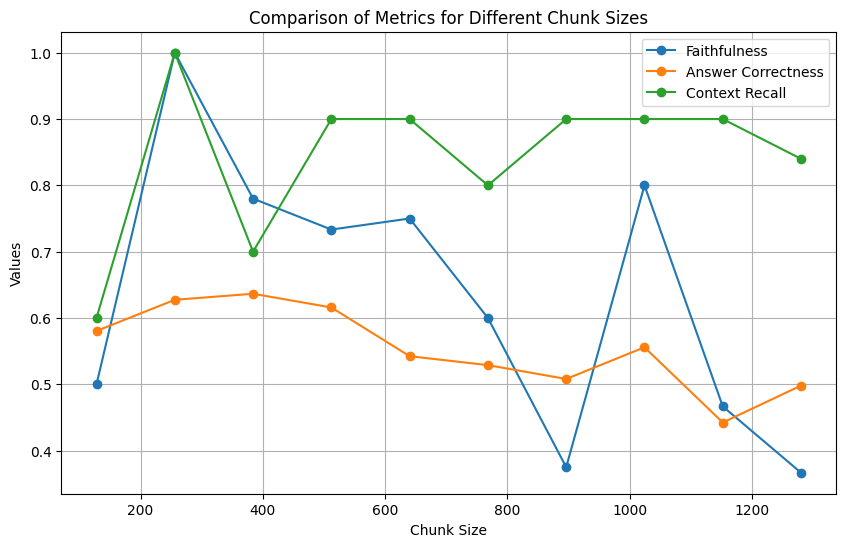

In [30]:
import matplotlib.pyplot as plt

# Organize data by chunk_size
chunk_sizes = sorted(set(d['chunk_size'] for d in test_results))
faithfulness = [d['faithfulness'] for d in test_results]
answer_correctness = [d['answer_correctness'] for d in test_results]
context_recall = [d['context_recall'] for d in test_results]

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(chunk_sizes, faithfulness, marker='o', label='Faithfulness')
plt.plot(chunk_sizes, answer_correctness, marker='o', label='Answer Correctness')
plt.plot(chunk_sizes, context_recall, marker='o', label='Context Recall')

plt.xlabel('Chunk Size')
plt.ylabel('Values')
plt.title('Comparison of Metrics for Different Chunk Sizes')
plt.legend()
plt.grid(True)
plt.show()

I suspect the Q&A sample set is too small to provider any meaningful results. In order to avoid evaluate throwing an exception, I found it necessary to break down the evaluation step into at most 50 evaluations at a time.

In [ ]:
test_results = []

for chunk_size in chunk_sizes:
    print(f"Chunk size: {chunk_size}")

    results_dict = {}
    results_dict['chunk_size'] = chunk_size

    retriever = vstore.as_retriever(search_kwargs={'k': 3, 'filter': {"chunk_size": chunk_size}})
    rag_chain = create_retrieval_chain(retriever, qa_chain)

    alice_ds = prepare_question_and_answer_dataset(test_questions_pass2[:49], test_ground_truth[:49], rag_chain)

    result = evaluate(alice_ds, [faithfulness],
                      llm=decoder_model,
                      embeddings=embedding_model,
                      run_config=run_config)
    results_dict['faithfulness'] = result['faithfulness']
    print(result)
    
    result = evaluate(alice_ds, [answer_correctness],
                      llm=decoder_model,
                      embeddings=embedding_model,
                      run_config=run_config)
    results_dict['answer_correctness'] = result['answer_correctness']
    print(result)
    
    result = evaluate(alice_ds, [context_recall],
                      llm=decoder_model,
                      embeddings=embedding_model,
                      run_config=run_config)
    results_dict['context_recall'] = result['context_recall']
    print(result)
    
    test_results.append(results_dict)
print(test_results)

In [ ]:
import matplotlib.pyplot as plt

# Organize data by chunk_size
chunk_sizes = sorted(set(d['chunk_size'] for d in test_results))
faithfulness = [d['faithfulness'] for d in test_results]
answer_correctness = [d['answer_correctness'] for d in test_results]
#answer_relevancy = [d['answer_relevancy'] for d in test_results]
context_recall = [d['context_recall'] for d in test_results]

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(chunk_sizes, faithfulness, marker='o', label='Faithfulness')
plt.plot(chunk_sizes, answer_correctness, marker='o', label='Answer Correctness')
# plt.plot(chunk_sizes, answer_relevancy, marker='o', label='Answer Relevancy')
plt.plot(chunk_sizes, context_recall, marker='o', label='Context Recall')

plt.xlabel('Chunk Size')
plt.ylabel('Values')
plt.title('Comparison of Metrics for Different Chunk Sizes')
plt.legend()
plt.grid(True)
plt.show()

This seems better. However, there appears to be a peak in performance between 384 and 512 so let's perform more evaluations in this range to see if we can find an optimal value.

In [ ]:
chunk_sizes = [x for x in range(416, 512, 32)] 
chunk_overlaps = [max(math.ceil(x * 0.2), 128) for x in chunk_sizes]

text_splittings = []

for chunk_size, chunk_overlap in zip(chunk_sizes, chunk_overlaps):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        is_separator_regex=False
    )
    text_splittings.append(text_splitter.create_documents([alice_in_wonderland], metadatas=[{"filename": "alice-modified.txt",
                                                                                             "chunk_size": chunk_size,
                                                                                            "chunk_overlap": chunk_overlap}]))
#
# Remember: Add the new embeddings to the vector store or else there will be no context.
# 
for text_splitting in text_splittings:
    inserted_ids = vstore.add_documents(text_splitting)
    print(f"\nInserted {len(inserted_ids)} documents.")


for chunk_size in chunk_sizes:
    print(f"Chunk size: {chunk_size}")

    results_dict = {}
    results_dict['chunk_size'] = chunk_size

    retriever = vstore.as_retriever(search_kwargs={'k': 3, 'filter': {"chunk_size": chunk_size}})
    rag_chain = create_retrieval_chain(retriever, qa_chain)

    alice_ds = prepare_question_and_answer_dataset(test_questions_pass2[:49], test_ground_truth[:49], rag_chain)

    result = evaluate(alice_ds, [faithfulness],
                      llm=decoder_model,
                      embeddings=embedding_model,
                      run_config=run_config)
    results_dict['faithfulness'] = result['faithfulness']
    print(result)
    
    result = evaluate(alice_ds, [answer_correctness],
                      llm=decoder_model,
                      embeddings=embedding_model,
                      run_config=run_config)
    results_dict['answer_correctness'] = result['answer_correctness']
    print(result)
        
    result = evaluate(alice_ds, [context_recall],
                      llm=decoder_model,
                      embeddings=embedding_model,
                      run_config=run_config)
    results_dict['context_recall'] = result['context_recall']
    print(result)
    
    test_results.append(results_dict)
print(test_results)

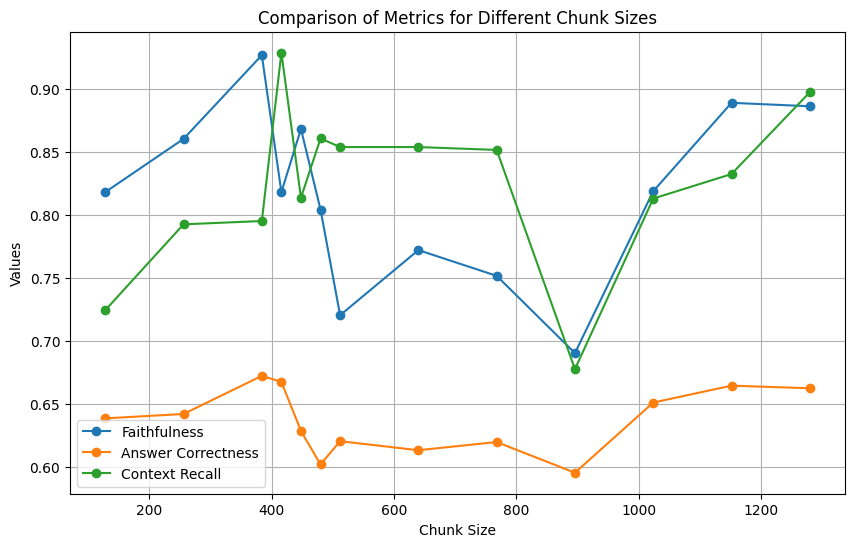

In [32]:
import matplotlib.pyplot as plt

# Organize data by chunk_size
chunk_sizes = sorted(set(d['chunk_size'] for d in test_results))
faithfulness = [d['faithfulness'] for d in test_results]
answer_correctness = [d['answer_correctness'] for d in test_results]
context_recall = [d['context_recall'] for d in test_results]

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(chunk_sizes, faithfulness, marker='o', label='Faithfulness')
plt.plot(chunk_sizes, answer_correctness, marker='o', label='Answer Correctness')
plt.plot(chunk_sizes, context_recall, marker='o', label='Context Recall')

plt.xlabel('Chunk Size')
plt.ylabel('Values')
plt.title('Comparison of Metrics for Different Chunk Sizes')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion
- `Ragas` is a useful python module for quantitatively measuring performance across a number of common metrics. However, during the experimentation we performed in this workbook, there's still some bugs to be ironed out. For example, even when using the latest development MAIN branch, I regularly experienced exceptions when evaluating more than 50 Q&A against a ground truth set of Q&A. I also found the evaluate function particularly sensitive to calculating `answer_relevancy`.
- `Ragas` also provides a helpful Q&A generator using a collection of source documents. Testing was limited to a single document, however the Q&A generated together were more challenging that I was initially expecting. Instead of generating questions such as "what item does the white rabbit carry in his waist-coat pocket?" it generated more challenging questions such as "What is the reaction of the baby to the chaos caused by the cook?".
- There appears to be a sweet-spot for "faithfulness", "answer correctness" and "context recall" with a chuck_size or approximately 400 (characters). Performance then decreases until we reach a `chunk_size` of around 900 (characters) after which it steady rises again. This suggests that using a `chunk_size` between 400 and 1200 doesn't actually improve performance for this dataset and questions. It only increases resource consumption of the vector store, CPU and GPU (LLM). It would be useful to extend testing past a `chunk_size` of 1280 to see whether the earlier maximums are local maximums. If performance significantly exceeds the performance with a chunk_size of 400 the additional resources may be worth it.
- Another dimension to explore is `k`, the number of vector embeddings to return per search. We used `k=3` during testing but it's plausible that increasing k to 5-7 with improve performance, especially with smaller `chunk_sizes`.